In [ ]:
# import libraries
import numpy as np
import os
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define load_data function
def load_data(directory):
    X, y = [], []

    for root, dirs, files in os.walk(directory):
        print(f"Current root: {root}")
        print(f"Subdirectories: {dirs}")
        print(f"Files: {files}")
        print('-' * 40)

        for file in files:
            if file.endswith('_emg.npy'):
                info_file = os.path.join(root, file.replace('_emg.npy', '_info.json'))
                emg_file = os.path.join(root, file)
                if os.path.exists(info_file):
                    with open(info_file, 'r') as f:
                        info = json.load(f)
                        sentence_index = info.get('sentence_index', -1)
                        if sentence_index != -1:
                            emg = np.load(emg_file)
                            X.append(emg)
                            y.append(sentence_index)

    return X, y

# Load data
directory = '/content/drive/MyDrive/silent_parallel_data/silent_sort'
X, y = load_data(directory)

Current root: /content/drive/MyDrive/silent_parallel_data/silent_sort
Subdirectories: ['5-9_silent']
Files: []
----------------------------------------
Current root: /content/drive/MyDrive/silent_parallel_data/silent_sort/5-9_silent
Subdirectories: []
Files: ['258_button.npy', '175_audio_clean.flac', '259_audio_clean.flac', '258_info.json', '58_emg.npy', '103_audio.flac', '76_info.json', '170_button.npy', '43_audio_clean.flac', '163_info.json', '174_info.json', '190_audio_clean.flac', '64_emg.npy', '240_emg.npy', '191_info.json', '259_audio.flac', '121_button.npy', '279_button.npy', '134_info.json', '127_audio.flac', '244_button.npy', '110_button.npy', '179_button.npy', '12_button.npy', '299_audio.flac', '52_button.npy', '183_audio_clean.flac', '54_info.json', '44_button.npy', '180_info.json', '189_emg.npy', '306_info.json', '51_emg.npy', '193_info.json', '307_audio.flac', '298_button.npy', '173_info.json', '169_audio_clean.flac', '270_emg.npy', '127_emg.npy', '229_audio_clean.flac', '

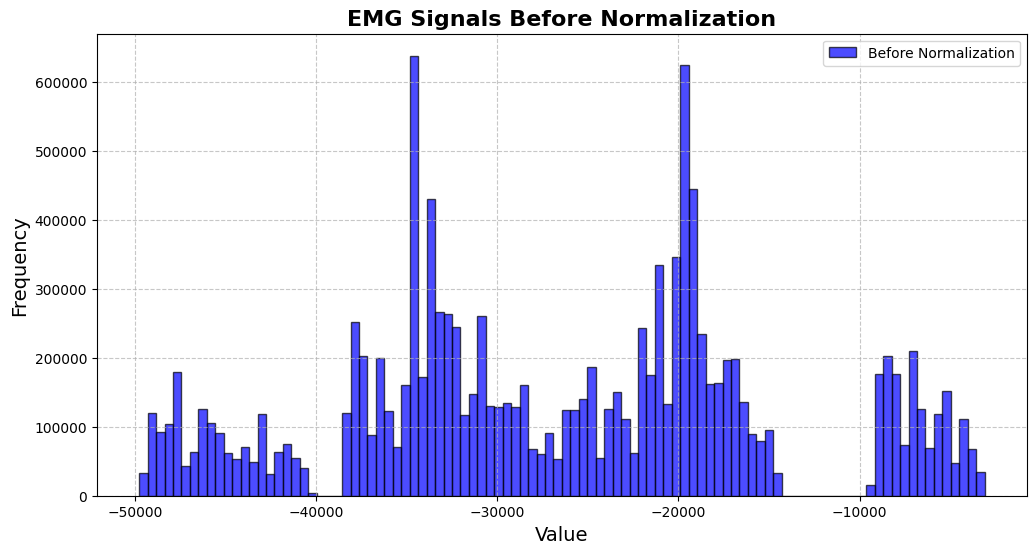

In [ ]:
# Function to recursively flatten and convert arrays/lists
def flatten_and_convert(lst):
    for item in lst:
        if isinstance(item, (list, np.ndarray)):
            yield from flatten_and_convert(item)
        else:
            yield float(item)

# Manually flatten the list and convert to floats
emg = list(flatten_and_convert(X))

# Convert to numpy array
emg_array = np.array(emg)

# Plot histogram before normalization
plt.figure(figsize=(12, 6))
plt.hist(emg_array, bins=100, alpha=0.7, color='blue', edgecolor='black', label="Before Normalization")
plt.title("EMG Signals Before Normalization", fontsize=16, fontweight='bold')
plt.xlabel("Value", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

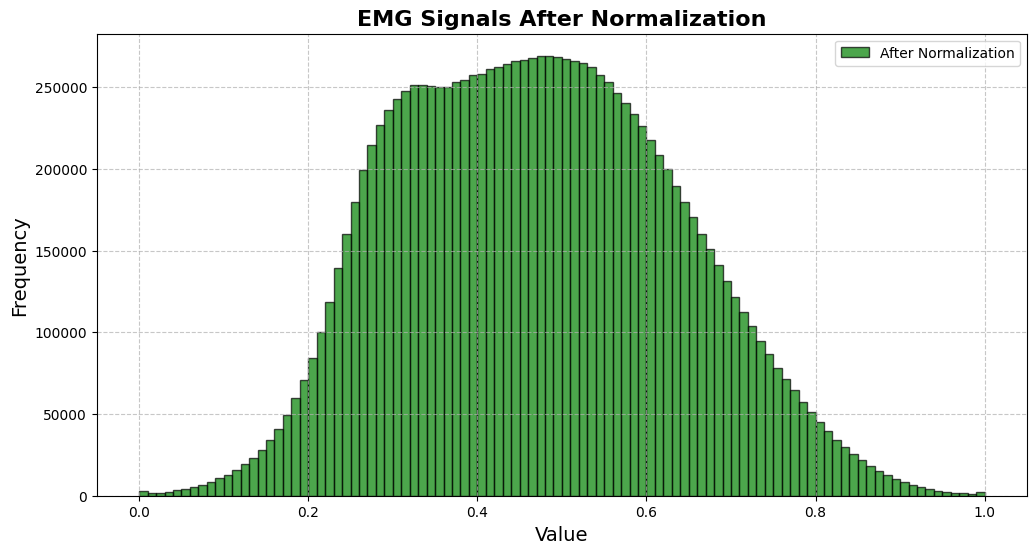

In [ ]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
X_normalized = [scaler.fit_transform(x) for x in X]
emg_normalized = list(flatten_and_convert(X_normalized))

# Convert to numpy array
emg_array_normalized = np.array(emg_normalized)

# Plot histogram after normalization
plt.figure(figsize=(12, 6))
plt.hist(emg_array_normalized, bins=100, alpha=0.7, color='green', edgecolor='black', label="After Normalization")
plt.title("EMG Signals After Normalization", fontsize=16, fontweight='bold')
plt.xlabel("Value", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# Pad sequences to ensure uniform length
X_padded = pad_sequences(X_normalized, padding='post', dtype='float32')  # Ensure dtype is float32

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Define the model
model = Sequential()

# Add Conv1D layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.01)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=2))

# Add another block of Conv1D layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Conv1D(filters=512, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=2))

# LSTM layers
model.add(LSTM(128, kernel_regularizer=l2(0.01), dropout=0.5, return_sequences=True))
model.add(LSTM(128, kernel_regularizer=l2(0.01), dropout=0.5, return_sequences=True))
model.add(LSTM(128, kernel_regularizer=l2(0.01), dropout=0.5, return_sequences=True))
model.add(LSTM(128, kernel_regularizer=l2(0.01), dropout=0.5))

# Add output layer
num_classes = max(y) + 1
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy', MeanSquaredError(), MeanAbsoluteError()]
)

history = model.fit(np.array(X_train), np.array(y_train), epochs=50,
                    validation_data=(np.array(X_test), np.array(y_test)), batch_size=32, verbose=1)


Epoch 1/50
6/6 [==============================] - 37s 3s/step - loss: 22.9237 - accuracy: 0.0000e+00 - mean_squared_error: 1015505.5625 - mean_absolute_error: 1005.8828 - val_loss: 20.5961 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1012612.7500 - val_mean_absolute_error: 1003.9991
Epoch 2/50
6/6 [==============================] - 9s 2s/step - loss: 19.3821 - accuracy: 0.0058 - mean_squared_error: 1015505.5625 - mean_absolute_error: 1005.8828 - val_loss: 17.5227 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1012612.7500 - val_mean_absolute_error: 1003.9990
Epoch 3/50
6/6 [==============================] - 10s 2s/step - loss: 16.2361 - accuracy: 0.0058 - mean_squared_error: 1015505.6875 - mean_absolute_error: 1005.8828 - val_loss: 15.3150 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1012612.9375 - val_mean_absolute_error: 1003.9991
Epoch 4/50
6/6 [==============================] - 10s 2s/step - loss: 13.4239 - accuracy: 0.0058 - mean_squared_error: 1015505.5625 -

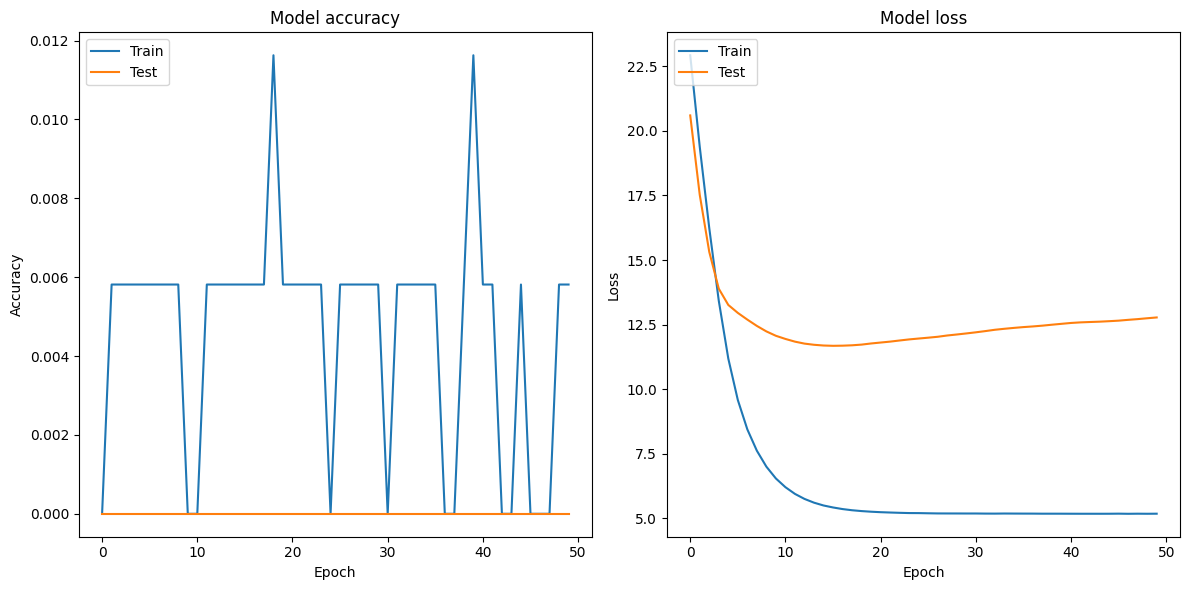

In [ ]:
# Plot accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model
loss, accuracy, mse, mae = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
print(f'Test loss: {loss:.3f}')
print(f'Test accuracy: {accuracy:.3f}')
print(f'Test MSE: {mse:.3f}')
print(f'Test MAE: {mae:.3f}')

# Calculate predictions for the test set
y_pred = model.predict(np.array(X_test))
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate RMSE
rmse = np.sqrt(np.mean((np.array(y_test) - y_pred_classes) ** 2))
print(f'Test RMSE: {rmse:.3f}')

# Calculate Huber Loss
huber_loss = Huber()
huber_loss_value = huber_loss(np.array(y_test), y_pred_classes).numpy()
print(f'Test Huber Loss: {huber_loss_value:.3f}')

Test loss: 12.779
Test accuracy: 0.000
Test MSE: 1012612.938
Test MAE: 1003.999
2/2 [==============================] - 2s 420ms/step
Test RMSE: 115.908
Test Huber Loss: 94.045


In [ ]:
# Make prediction
prediction = model.predict(np.array([X_test[0]]))
predicted_class = np.argmax(prediction)
print(f'Predicted class: {predicted_class}')

1/1 [==============================] - 1s 813ms/step
Predicted class: 910


In [ ]:
# Save model
model.save('/content/drive/MyDrive/ProjectDataset_h2/emg_model_open_source.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.experimental_new_converter = True
converter.experimental_new_quantizer = True
converter.experimental_new_quantizer_debug = True

tflite_model = converter.convert()

# Save the model to TensorFlow Lite file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)